# Continuous Control

---

In this notebook, I present my DDPG solution to the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.




### Start the Environment
Set the Unity Enviroment path (Windows x64 executable)

In [1]:
from unityagents import UnityEnvironment
import numpy as np
env = UnityEnvironment(file_name=r'.\Reacher_Windows_x86_64_20\Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Set the environments **_brain_**.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### Examine the State and Action Spaces
The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### Training the agent

In [5]:
from collections import deque
import matplotlib.pyplot as plt
from ddpg_agent import Agent
import torch
import time

%matplotlib inline

agent = Agent(state_size, action_size, random_seed=1)

Device used:  cpu


In [4]:


def ddpg(n_episodes=300, max_t=1000, print_every=1, success_criteria_count=100):
    scores_deque = deque(maxlen=success_criteria_count)
    scores = []
    agent_mean_scores = []
    agent_mean_scores_100eps = []

    for i_episode in range(1, n_episodes+1):    
        start_t = time.time()
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        score = np.zeros((num_agents,))   
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]   
            next_state = env_info.vector_observations         
            reward = env_info.rewards                         
            done = env_info.local_done                
            agent.step(state, action, reward, next_state, done, t)
            state = next_state
            score += reward
            if np.any(done):
                break 
            
        scores_deque.append(score)
        scores.append(score)
        agent_mean_scores.append(np.mean(score))
        agent_mean_scores_100eps.append(np.mean(scores_deque))

        end_t = time.time()
               
        if np.mean(scores_deque)>=30:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_ddpg.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_ddpg.pth')
        if i_episode % print_every == 0:
            print('\rAgents Mean Score in Episode {:03d}: {:.2f}, \tAgents Mean Score over last 100 episodes: {:.2f} (time per eps:{:.1f} secs)'.format(i_episode,np.mean(score), np.mean(scores_deque), end_t - start_t), end="\n")
    return scores, agent_mean_scores, agent_mean_scores_100eps

scores, agent_mean_scores, agent_mean_scores_100eps = ddpg()


The device to use:  cpu
Agents Mean Score in Episode 001: 0.59, 	Agents Mean Score over last 100 episodes: 0.59 (time per eps:55.0 secs)
Agents Mean Score in Episode 002: 0.14, 	Agents Mean Score over last 100 episodes: 0.36 (time per eps:54.9 secs)
Agents Mean Score in Episode 003: 0.00, 	Agents Mean Score over last 100 episodes: 0.24 (time per eps:55.8 secs)
Agents Mean Score in Episode 004: 0.00, 	Agents Mean Score over last 100 episodes: 0.18 (time per eps:57.6 secs)
Agents Mean Score in Episode 005: 0.01, 	Agents Mean Score over last 100 episodes: 0.15 (time per eps:56.4 secs)
Agents Mean Score in Episode 006: 0.06, 	Agents Mean Score over last 100 episodes: 0.13 (time per eps:56.7 secs)
Agents Mean Score in Episode 007: 0.71, 	Agents Mean Score over last 100 episodes: 0.22 (time per eps:56.3 secs)
Agents Mean Score in Episode 008: 1.20, 	Agents Mean Score over last 100 episodes: 0.34 (time per eps:56.6 secs)
Agents Mean Score in Episode 009: 1.65, 	Agents Mean Score over last 100

Agents Mean Score in Episode 073: 27.51, 	Agents Mean Score over last 100 episodes: 10.79 (time per eps:64.5 secs)
Agents Mean Score in Episode 074: 26.77, 	Agents Mean Score over last 100 episodes: 11.00 (time per eps:64.8 secs)
Agents Mean Score in Episode 075: 28.00, 	Agents Mean Score over last 100 episodes: 11.23 (time per eps:64.4 secs)
Agents Mean Score in Episode 076: 28.70, 	Agents Mean Score over last 100 episodes: 11.46 (time per eps:64.1 secs)
Agents Mean Score in Episode 077: 30.74, 	Agents Mean Score over last 100 episodes: 11.71 (time per eps:65.2 secs)
Agents Mean Score in Episode 078: 30.67, 	Agents Mean Score over last 100 episodes: 11.95 (time per eps:64.6 secs)
Agents Mean Score in Episode 079: 30.99, 	Agents Mean Score over last 100 episodes: 12.19 (time per eps:64.3 secs)
Agents Mean Score in Episode 080: 32.07, 	Agents Mean Score over last 100 episodes: 12.44 (time per eps:64.3 secs)
Agents Mean Score in Episode 081: 34.92, 	Agents Mean Score over last 100 episod

KeyboardInterrupt: 

### Plot the scores.

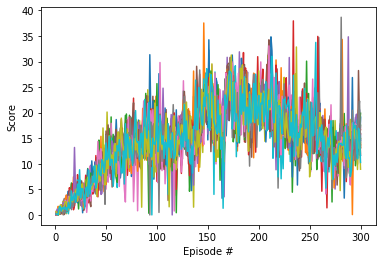

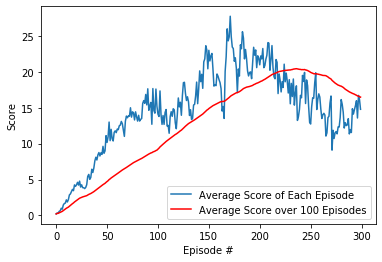

In [5]:
# plot the scores of every agent
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# plot the average scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), agent_mean_scores, label='Average Score of Each Episode')
plt.plot(np.arange(len(scores)), agent_mean_scores_100eps, c='r', label='Average Score over 100 Episodes')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='lower right')
plt.show()

In [7]:
torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_ddpg.pth')

### Seeing the trained agent in action

In [6]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_ddpg.pth'))
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
i = 0
while True:
    i+=1
    actions = agent.act(states)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        print('Total number of timesteps: {:d}'.format(i))
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total number of timesteps: 1001
Total score (averaged over agents) this episode: 20.01149955270812


### Close the environment.

In [45]:
env.reset()
env.close()